# Chess Clustering

### Probleem
Ik heb een data set gekozen met allemaal statestieken van een chess game. Van dus zo'n chess game zijn er verschillende features aanwezig, zoals de elo, wanneer er gespeeld wordt, welke moves ze zetten, etc.

Nu zijn er dus 4 verschillende game modes die je kan spelen met chess online. Namelijk: 
- Bullet: ~3 minuten
- Blitz: niet meer dan 10 minuten
- Rapid: tussen 10 en 60 minuten
- Classical: ~ 4 uur

Ik wil met alle data van een chess game kunnen voorspellen (clusteren) welke type game er gespeelt wordt.

# Visualizing the Data

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_22388\4044612967.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Importing the data
chess = pd.read_csv('games_metadata_profile.csv')
chess.head()

,Unnamed: 0,GameID,Event,Site,Date,Time,White,WhiteElo,WhiteRatingDiff,White_is_deleted,...,Black_createdAt,Black_playTime_total,Black_count_all,Black_title,Moves,TotalMoves,ECO,Opening,TimeControl,Result
0,0,1,Rated Classical game,https://lichess.org/thHVpOWb,2017.04.30,22:00:22,laserany,1462,10.0,True,...,1.483452e+12,358763.0,709.0,NaN,e4 {[%eval 0.18] [%clk 0:10:00]} e5 {[%eval 0....,37,C61,Ruy Lopez: Bird Variation,600+0,1-0
1,1,2,Rated Bullet game,https://lichess.org/VkrZh2mi,2017.04.30,22:00:27,aezr777,1384,12.0,False,...,1.424389e+12,501634.0,2610.0,NaN,e4 {[%eval 0.15] [%clk 0:01:00]} d5 {[%eval 0....,49,D00,Blackmar-Diemer Gambit: Zeller Defense,60+0,1-0
2,2,3,Rated Classical tournament https://lichess.org...,https://lichess.org/SBQLVdig,2017.04.30,22:01:00,Parapixel,1895,13.0,False,...,NaN,NaN,NaN,NaN,e4 {[%eval 0.18] [%clk 0:10:00]} c5 {[%eval 0....,103,B27,Sicilian Defense: Hyperaccelerated Dragon,600+0,1-0
3,3,4,Rated Classical game,https://lichess.org/eKevl4x2,2017.04.30,22:01:02,ByWitcher,1511,24.0,False,...,1.492805e+12,24294725.0,20709.0,NaN,e4 {[%eval 0.25] [%clk 0:10:00]} e5 {[%eval 0....,61,C40,King's Pawn Game: Damiano Defense,600+0,1-0
4,4,5,Rated Blitz game,https://lichess.org/jFT4MHsZ,2017.04.30,22:01:18,Phililipov,1886,-4.0,False,...,NaN,NaN,NaN,NaN,e4 {[%eval 0.24] [%clk 0:03:00]} d6 {[%eval 0....,66,B07,Pirc Defense,180+5,0-1


<Axes: xlabel='Result', ylabel='count'>

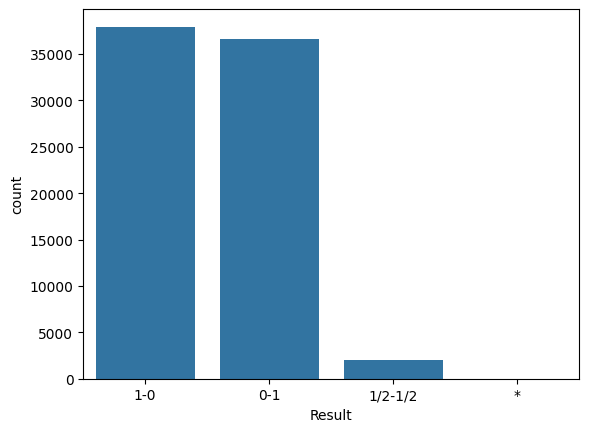

In [3]:
# Plot black vs white wins
sns.countplot(x='Result', data=chess)


Hier kan je zien dat er vooral 1 winnaar is, en vrij weinig gelijk wordt gespeeld. Wat opvalt is dat er nog een categorie is, genaamd '*'. Ik neem aan dat dit betekend dat het spel niet is afgemaakt, door wat voor omstandigheden dan ook.

Hier zie je ook dat White meer wint dan zwart. Dit betekend dus dat je een hogere kans hebt van winnen als je White bent en dus als eerst mag bewegen.

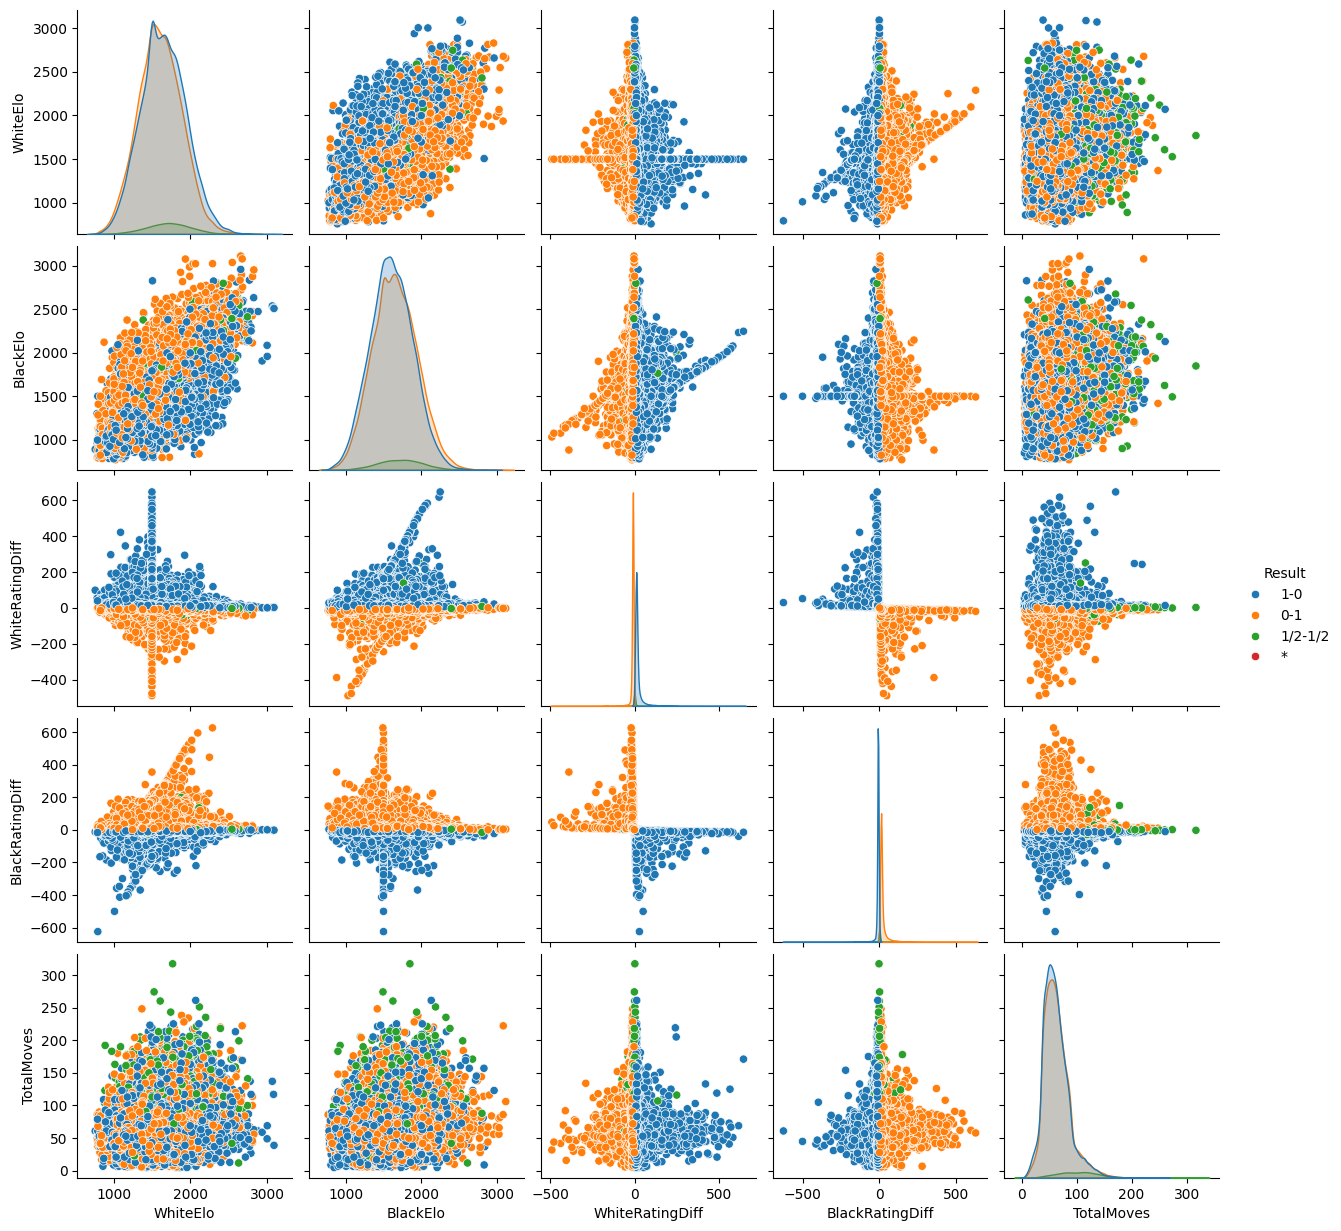

In [4]:
from pandas.plotting import scatter_matrix

# Plotting the scatter matrix
plt.rcParams['figure.figsize'] = [15,15]

sns.pairplot(chess, hue='Result', vars=['WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'TotalMoves'])

plt.show()


Uit deze scatter matrix vallen een paar dingen op.

De meeste opvallende dingen, zie je bij de TotalMoves. Hier zie je de volgende dingen:
- De TotalMoves zijn hoger, als de White/BlackRatingDiff laag is. Dit betekend dus dat beide spelers even goed zijn, en dus gaat het spel langer door.
- Ook zie je dat als de RatingDiff laag is, de kans op gelijk spel veel hoger is, eigenlijk is er alleen maar gelijk spel als we spelers even goed zijn.


# Cleaning the Data

Helaas is de data nog niet klaar om gevisualiseerd te worden, dus ik ga het eerst opschonen zodat we het kunnen bekijken.

In [5]:
# Cleaing the data
from sklearn.preprocessing import OneHotEncoder

# Encoding the Result column
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(chess[['Result']]).toarray())

# Renaming the columns
column_names = ['*', 'Black wins', 'White wins', 'Draw']
enc_df.columns = column_names

# Merging the data
chess = chess.join(enc_df)
chess.head()

,Unnamed: 0,GameID,Event,Site,Date,Time,White,WhiteElo,WhiteRatingDiff,White_is_deleted,...,Moves,TotalMoves,ECO,Opening,TimeControl,Result,*,Black wins,White wins,Draw
0,0,1,Rated Classical game,https://lichess.org/thHVpOWb,2017.04.30,22:00:22,laserany,1462,10.0,True,...,e4 {[%eval 0.18] [%clk 0:10:00]} e5 {[%eval 0....,37,C61,Ruy Lopez: Bird Variation,600+0,1-0,0.0,0.0,1.0,0.0
1,1,2,Rated Bullet game,https://lichess.org/VkrZh2mi,2017.04.30,22:00:27,aezr777,1384,12.0,False,...,e4 {[%eval 0.15] [%clk 0:01:00]} d5 {[%eval 0....,49,D00,Blackmar-Diemer Gambit: Zeller Defense,60+0,1-0,0.0,0.0,1.0,0.0
2,2,3,Rated Classical tournament https://lichess.org...,https://lichess.org/SBQLVdig,2017.04.30,22:01:00,Parapixel,1895,13.0,False,...,e4 {[%eval 0.18] [%clk 0:10:00]} c5 {[%eval 0....,103,B27,Sicilian Defense: Hyperaccelerated Dragon,600+0,1-0,0.0,0.0,1.0,0.0
3,3,4,Rated Classical game,https://lichess.org/eKevl4x2,2017.04.30,22:01:02,ByWitcher,1511,24.0,False,...,e4 {[%eval 0.25] [%clk 0:10:00]} e5 {[%eval 0....,61,C40,King's Pawn Game: Damiano Defense,600+0,1-0,0.0,0.0,1.0,0.0
4,4,5,Rated Blitz game,https://lichess.org/jFT4MHsZ,2017.04.30,22:01:18,Phililipov,1886,-4.0,False,...,e4 {[%eval 0.24] [%clk 0:03:00]} d6 {[%eval 0....,66,B07,Pirc Defense,180+5,0-1,0.0,1.0,0.0,0.0


In [9]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Relevant features
chess_selected = chess[['Result', 'Event', 'WhiteElo', 'BlackElo', 'TotalMoves', 'ECO', 'Opening', 'TimeControl']]

# One-hot encode categorical variables
one_hot_cols = ['ECO', 'Opening', 'TimeControl', 'Result', 'Event']
one_hot_enc = OneHotEncoder()
one_hot_encoded = one_hot_enc.fit_transform(chess_selected[one_hot_cols])

# Convert sparse matrix to a dense one and create DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded.toarray(), columns=one_hot_enc.get_feature_names_out(one_hot_cols))

chess_selected = pd.concat([chess_selected.drop(one_hot_cols, axis=1), one_hot_df], axis=1)

# Scale numerical variables
scaler = StandardScaler()
chess_selected[['WhiteElo', 'BlackElo', 'TotalMoves']] = scaler.fit_transform(chess_selected[['WhiteElo', 'BlackElo', 'TotalMoves']])

chess_selected.head()


,WhiteElo,BlackElo,TotalMoves,ECO_A00,ECO_A01,ECO_A02,ECO_A03,ECO_A04,ECO_A05,ECO_A06,...,Event_Rated UltraBullet tournament https://lichess.org/tournament/ykvpaXMN,Event_Rated UltraBullet tournament https://lichess.org/tournament/yxHSNU7Y,Event_Rated UltraBullet tournament https://lichess.org/tournament/z42R6sR0,Event_Rated UltraBullet tournament https://lichess.org/tournament/zCThwrev,Event_Rated UltraBullet tournament https://lichess.org/tournament/zMwfLff6,Event_Rated UltraBullet tournament https://lichess.org/tournament/zaAdQ7oS,Event_Rated UltraBullet tournament https://lichess.org/tournament/zaf8WQdc,Event_Rated UltraBullet tournament https://lichess.org/tournament/zxII6F7H,Event_Rated UltraBullet tournament https://lichess.org/tournament/zypTtGZl,Event_Rated UltraBullet tournament https://lichess.org/tournament/zzU6Q8Kj
0,-0.574358,-0.600627,-1.073096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.844816,-0.811358,-0.595723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.927032,1.126679,1.552455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.404454,-0.092799,-0.118350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.895826,1.928149,0.080555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Hier encoded we alle benodigden kolommen, zodat we de data aan een model kunnen geven.



# Training the Model

In [10]:
from sklearn.cluster import KMeans

# K Nearest Neighbors
kmeans = KMeans(n_clusters=3)

# Fit the model
kmeans.fit(chess_selected)

# Predict the clusters
clusters = kmeans.predict(chess_selected)

# Add the clusters to the dataframe
chess_selected['Cluster'] = clusters

Text(0.5, 0, 'Black Elo and Total Moves')

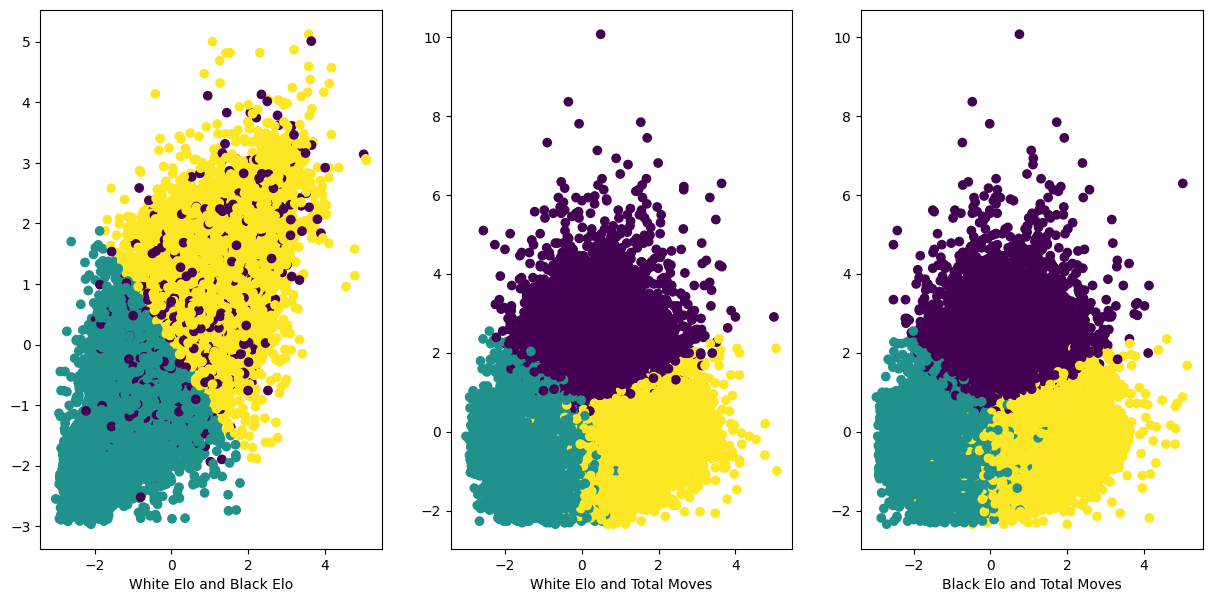

In [20]:
# Plot the clusters
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

axs[0].scatter(chess_selected['WhiteElo'], chess_selected['BlackElo'], c=chess_selected['Cluster'], cmap='viridis')
axs[0].set_xlabel('White Elo and Black Elo')

axs[1].scatter(chess_selected['WhiteElo'], chess_selected['TotalMoves'], c=chess_selected['Cluster'], cmap='viridis')
axs[1].set_xlabel('White Elo and Total Moves')

axs[2].scatter(chess_selected['BlackElo'], chess_selected['TotalMoves'], c=chess_selected['Cluster'], cmap='viridis')
axs[2].set_xlabel('Black Elo and Total Moves')

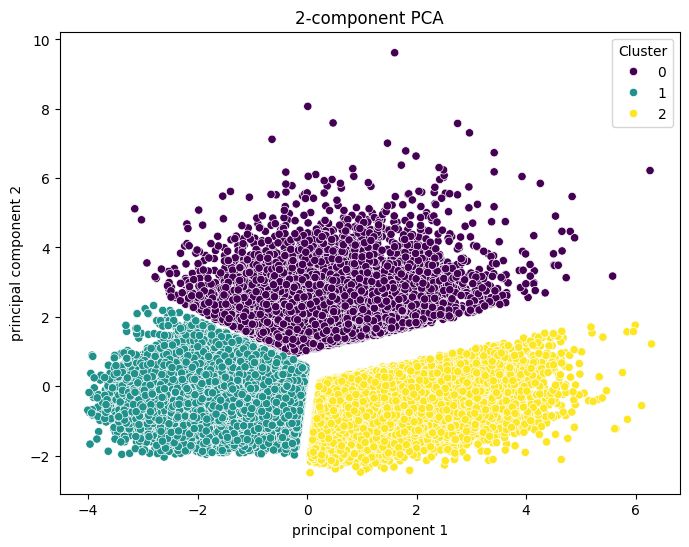

In [11]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(chess_selected)

# Create a DataFrame with the principal components
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Add the cluster assignments to the DataFrame
principalDf['Cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=principalDf, palette='viridis')
plt.title('2-component PCA')
plt.show()



In [12]:
cluster_means = chess_selected.groupby('Cluster').mean()

cluster_means


,WhiteElo,BlackElo,TotalMoves,ECO_A00,ECO_A01,ECO_A02,ECO_A03,ECO_A04,ECO_A05,ECO_A06,...,Event_Rated UltraBullet tournament https://lichess.org/tournament/ykvpaXMN,Event_Rated UltraBullet tournament https://lichess.org/tournament/yxHSNU7Y,Event_Rated UltraBullet tournament https://lichess.org/tournament/z42R6sR0,Event_Rated UltraBullet tournament https://lichess.org/tournament/zCThwrev,Event_Rated UltraBullet tournament https://lichess.org/tournament/zMwfLff6,Event_Rated UltraBullet tournament https://lichess.org/tournament/zaAdQ7oS,Event_Rated UltraBullet tournament https://lichess.org/tournament/zaf8WQdc,Event_Rated UltraBullet tournament https://lichess.org/tournament/zxII6F7H,Event_Rated UltraBullet tournament https://lichess.org/tournament/zypTtGZl,Event_Rated UltraBullet tournament https://lichess.org/tournament/zzU6Q8Kj
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.272099,0.272514,1.757572,0.035834,0.009979,0.005171,0.002994,0.015059,0.000816,0.004173,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.784681,-0.783838,-0.333738,0.064075,0.009677,0.002980,0.003292,0.012684,0.000284,0.007378,...,0.000341,0.000085,0.000000,0.000085,0.000028,0.000028,0.000000,0.000028,0.000028,0.000057
2,0.813785,0.812654,-0.251297,0.054169,0.013402,0.005381,0.004984,0.018254,0.001122,0.006074,...,0.000231,0.000000,0.000066,0.000033,0.000099,0.000066,0.000033,0.000033,0.000000,0.000000


# Evaluate

Uit deze clusters valt weining aan op te merken. Het model heeft de data geclusterd in 3 clusters, zoals aangeven. Maar uiteindelijk is er weinig uit te halen, omdat de data gestandadiseert is en niet meer te lezen is.

Wat wel opvalt, is ondanks ik 3 clusters heb gekozen, er alsnog een duidelijke scheiding is tussen White en BlackElo.